In [2]:
import findspark
findspark.init('/home/hb/Downloads/spark-3.3.2-bin-hadoop3')
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('cluster').getOrCreate()

23/05/02 22:12:05 WARN Utils: Your hostname, hb resolves to a loopback address: 127.0.1.1; using 192.168.1.6 instead (on interface wlp3s0)
23/05/02 22:12:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/02 22:12:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
df = spark.read.csv("uber-raw-data-aug14.csv", inferSchema=True, header=True)

In [24]:
num_rows = df.count()
num_cols = len(df.columns)
print("Number of rows: ", num_rows)
print("Number of columns: ", num_cols)

Number of rows:  829275
Number of columns:  4


In [22]:
df.toPandas()

,Date/Time,Lat,Lon,Base
0,8/1/2014 0:03:00,40.7366,-73.9906,B02512
1,8/1/2014 0:09:00,40.7260,-73.9918,B02512
2,8/1/2014 0:12:00,40.7209,-74.0507,B02512
3,8/1/2014 0:12:00,40.7387,-73.9856,B02512
4,8/1/2014 0:12:00,40.7323,-74.0077,B02512
...,...,...,...,...
829270,8/31/2014 23:55:00,40.7552,-73.9753,B02764
829271,8/31/2014 23:55:00,40.7552,-73.9753,B02764
829272,8/31/2014 23:55:00,40.7617,-73.9788,B02764
829273,8/31/2014 23:59:00,40.7395,-73.9889,B02764


In [23]:
df.describe().toPandas()

,summary,Date/Time,Lat,Lon,Base
0,count,829275,829275,829275,829275
1,mean,None,40.737780735824096,-73.97016031316342,None
2,stddev,None,0.043628060846870244,0.061482728345169296,None
3,min,8/1/2014 0:00:00,39.6569,-74.7737,B02512
4,max,8/9/2014 9:59:00,41.3182,-72.3359,B02764


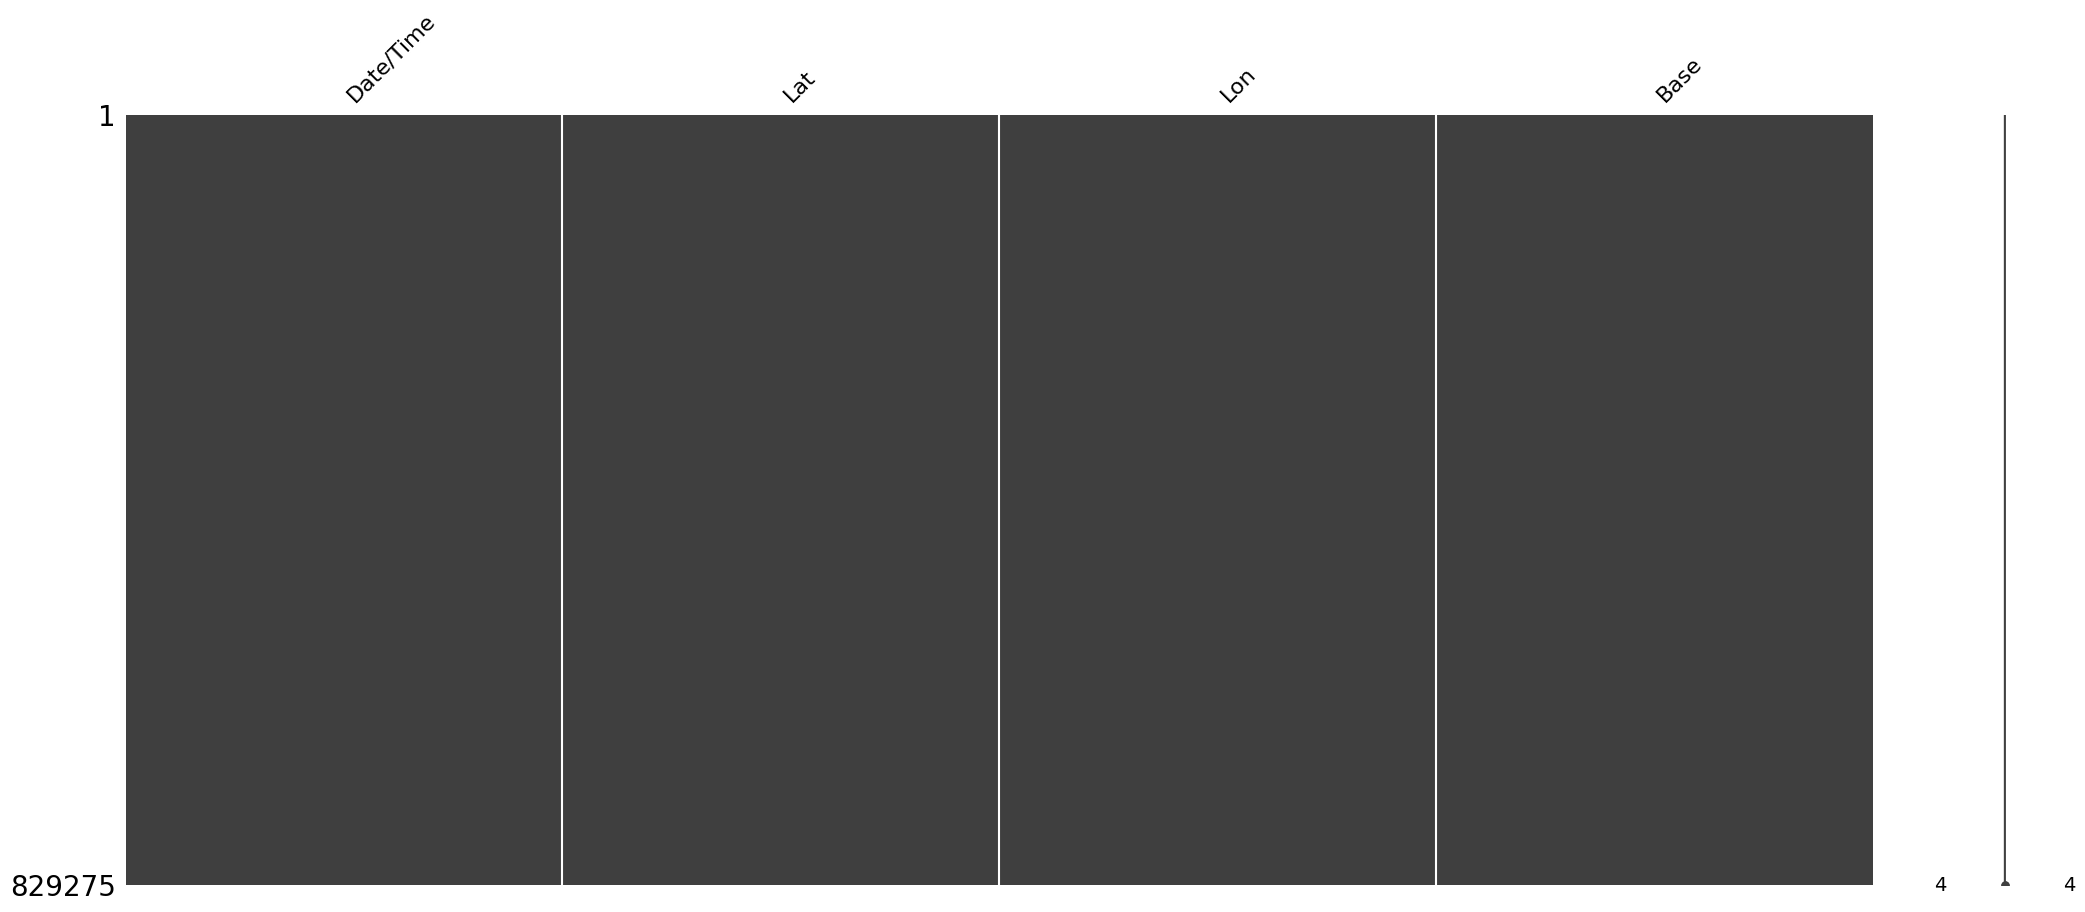

,Date/Time,Lat,Lon,Base
0,0,0,0,0


In [24]:
import missingno as msno
import matplotlib.pyplot as plt
import pyspark.sql.functions as F

missing_df = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
missing = missing_df.toPandas().transpose()
missing.columns = ['count']
missing['percentage'] = (missing['count']/df.count())*100

# missing value heatmap
msno.matrix(df.toPandas())
plt.show()

missing_df.toPandas()

# split data

In [140]:
from pyspark.sql.functions import split

df = df.withColumn('date', split(df['Date/Time'], ' ')[0]).withColumn('time', split(df['Date/Time'], ' ')[1]).drop('Date/Time')

In [141]:
df.toPandas()

,Lat,Lon,Base,date,time
0,40.7366,-73.9906,B02512,8/1/2014,0:03:00
1,40.7260,-73.9918,B02512,8/1/2014,0:09:00
2,40.7209,-74.0507,B02512,8/1/2014,0:12:00
3,40.7387,-73.9856,B02512,8/1/2014,0:12:00
4,40.7323,-74.0077,B02512,8/1/2014,0:12:00
...,...,...,...,...,...
829270,40.7552,-73.9753,B02764,8/31/2014,23:55:00
829271,40.7552,-73.9753,B02764,8/31/2014,23:55:00
829272,40.7617,-73.9788,B02764,8/31/2014,23:55:00
829273,40.7395,-73.9889,B02764,8/31/2014,23:59:00


In [34]:
from pyspark.sql.functions import count

education_counts = df.groupBy('Lat').agg(count('*').alias('count')).orderBy('count', ascending=False)
education_counts.show()

education_counts = df.groupBy('Lon').agg(count('*').alias('count')).orderBy('count', ascending=False)
education_counts.show()

education_counts = df.groupBy('Base').agg(count('*').alias('count')).orderBy('count', ascending=False)
education_counts.show()

education_counts = df.groupBy('date').agg(count('*').alias('count')).orderBy('count', ascending=False)
education_counts.show()

education_counts = df.groupBy('time').agg(count('*').alias('count')).orderBy('count', ascending=False)
education_counts.show()

+-------+-----+
|    Lat|count|
+-------+-----+
|40.6448| 2873|
| 40.774| 2746|
|40.7741| 2645|
|40.6447| 2488|
|40.7739| 2167|
|40.7514| 1599|
|40.7406| 1548|
| 40.756| 1455|
|40.7685| 1452|
|40.7641| 1409|
|40.7405| 1401|
| 40.742| 1394|
|40.7644| 1393|
|40.7643| 1377|
|40.7559| 1375|
|40.7198| 1372|
|40.7256| 1358|
|40.7552| 1358|
|40.7591| 1357|
|40.7407| 1351|
+-------+-----+
only showing top 20 rows



+--------+-----+
|     Lon|count|
+--------+-----+
|-73.9888| 2188|
|-73.9889| 2088|
|-73.9887| 2007|
|-73.9918| 1942|
| -73.989| 1882|
| -73.992| 1861|
|-73.9872| 1852|
|-73.9915| 1851|
|-73.9837| 1829|
|-73.9917| 1829|
|-73.9898| 1819|
|-73.9919| 1802|
|-73.9873| 1800|
|-73.9935| 1799|
|-73.9886| 1795|
|-73.9913| 1792|
|-73.9896| 1789|
|-73.9916| 1784|
|-73.9874| 1783|
|-73.9832| 1779|
+--------+-----+
only showing top 20 rows



+------+------+
|  Base| count|
+------+------+
|B02617|355803|
|B02598|220129|
|B02682|173280|
|B02764| 48591|
|B02512| 31472|
+------+------+



+---------+-----+
|     date|count|
+---------+-----+
| 8/7/2014|32759|
| 8/1/2014|32353|
|8/21/2014|32304|
| 8/6/2014|30495|
|8/14/2014|30457|
| 8/8/2014|30411|
|8/13/2014|29788|
|8/12/2014|29646|
|8/22/2014|29512|
|8/15/2014|28974|
| 8/2/2014|28678|
|8/28/2014|28597|
| 8/5/2014|28094|
|8/20/2014|27955|
|8/29/2014|27424|
|8/23/2014|27097|
|8/27/2014|27018|
| 8/9/2014|26286|
|8/16/2014|26234|
| 8/4/2014|24952|
+---------+-----+
only showing top 20 rows



+--------+-----+
|    time|count|
+--------+-----+
|18:15:00| 1052|
|17:15:00| 1022|
|17:10:00| 1020|
|17:14:00| 1011|
|17:19:00| 1010|
|17:08:00| 1009|
|18:14:00| 1003|
|17:50:00|  994|
|17:16:00|  992|
|17:45:00|  989|
|17:43:00|  987|
|17:23:00|  985|
|17:03:00|  985|
|17:44:00|  984|
|17:07:00|  980|
|17:25:00|  977|
|17:13:00|  976|
|16:08:00|  976|
|18:22:00|  975|
|17:17:00|  975|
+--------+-----+
only showing top 20 rows



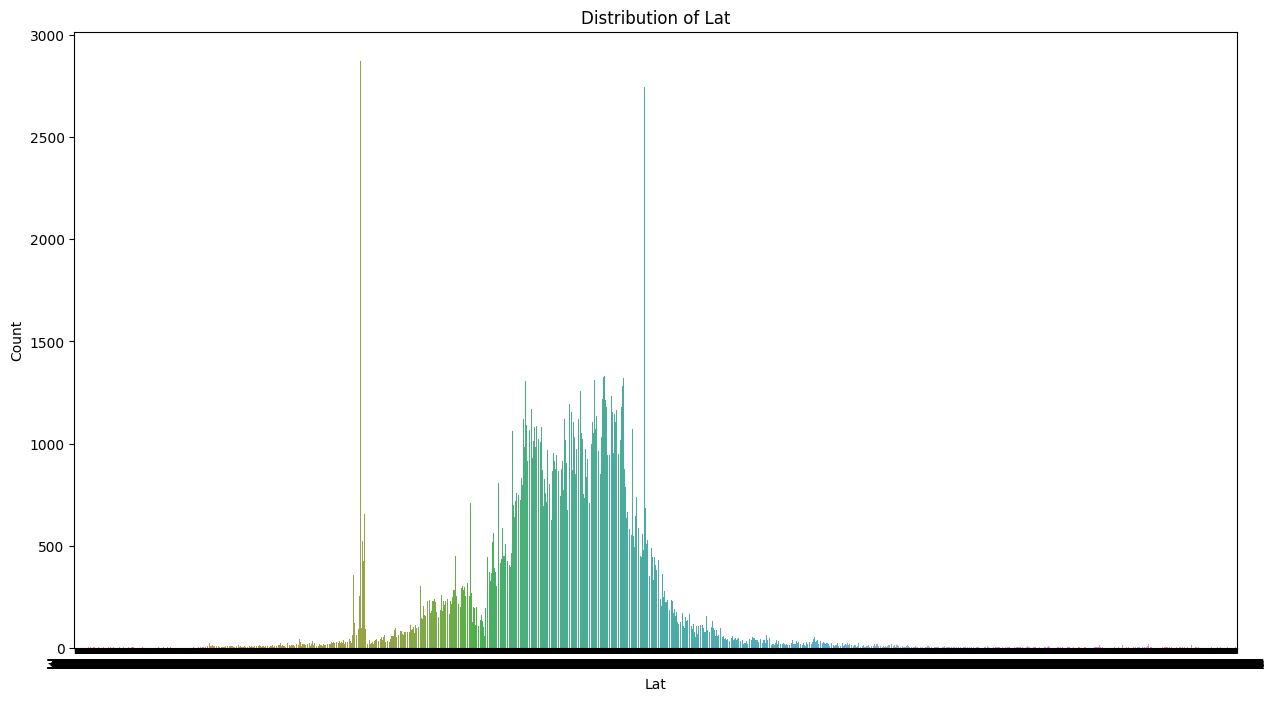

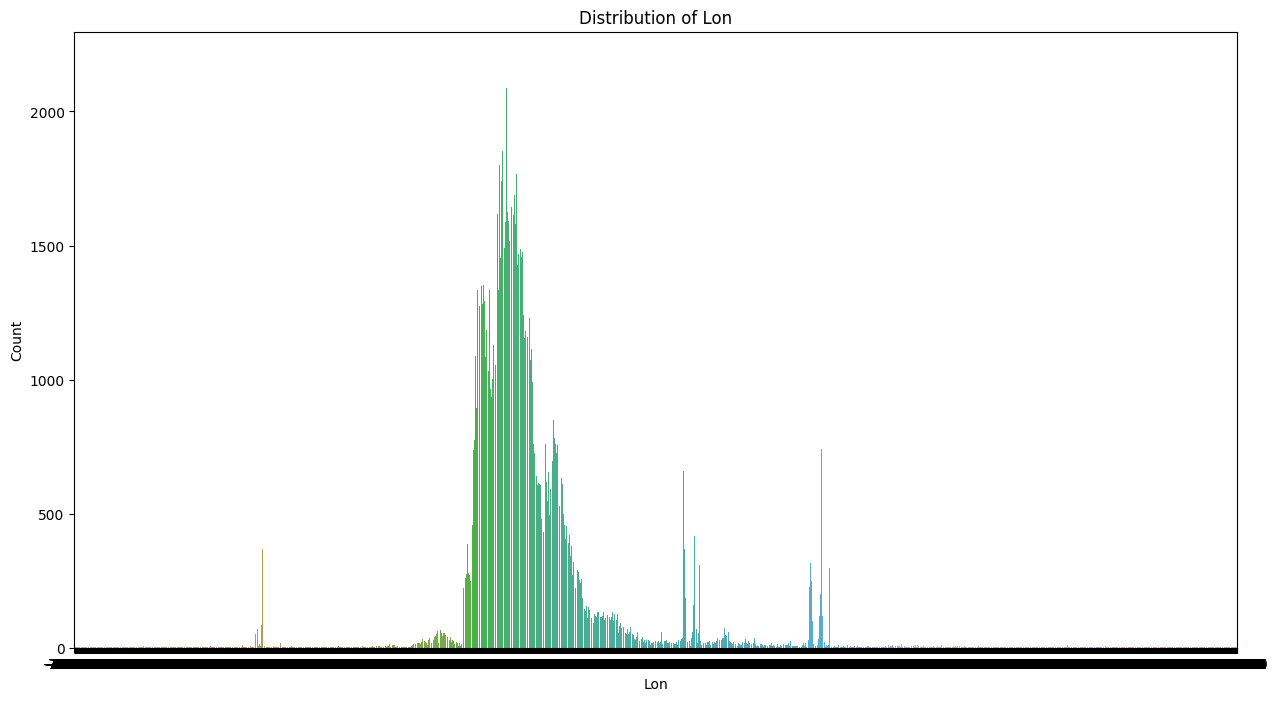

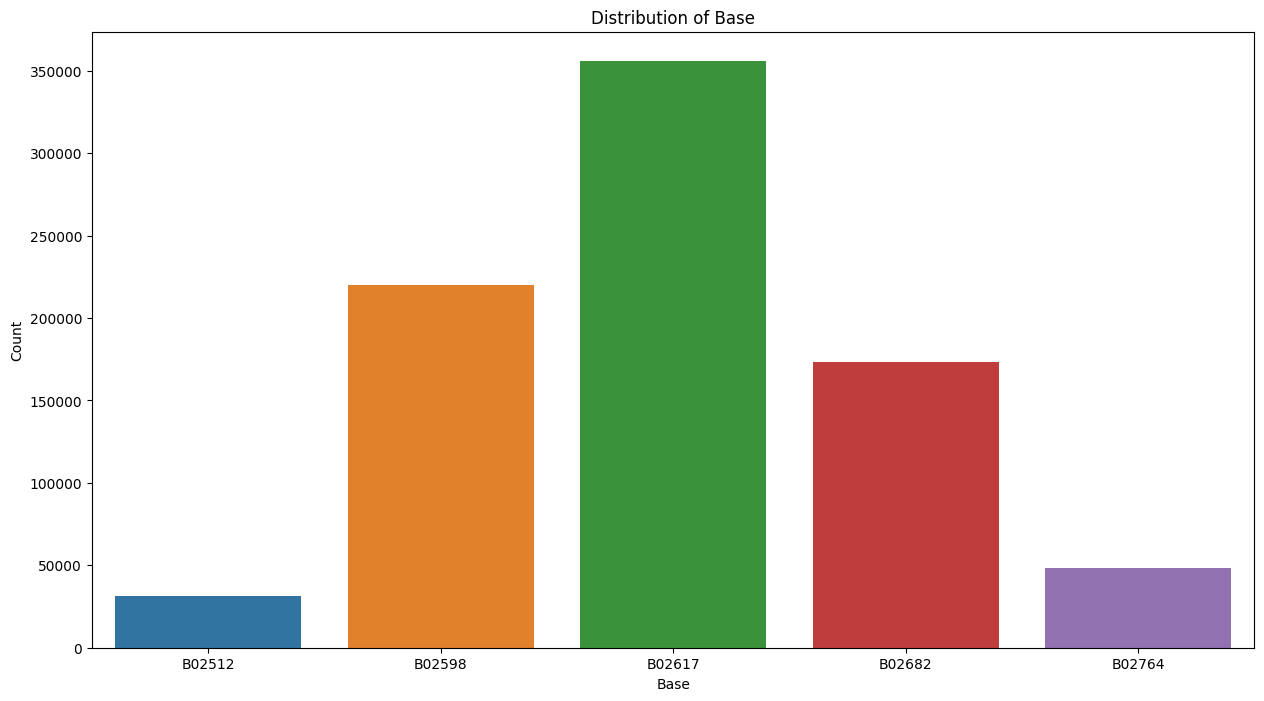

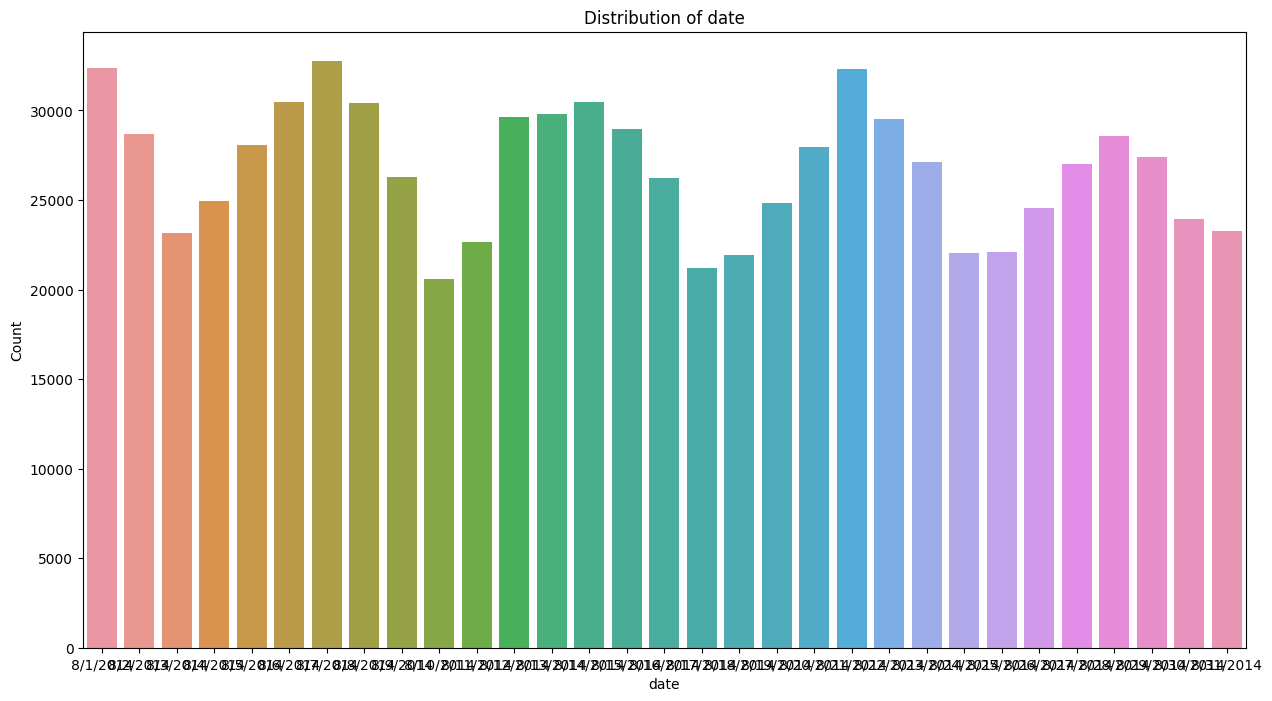

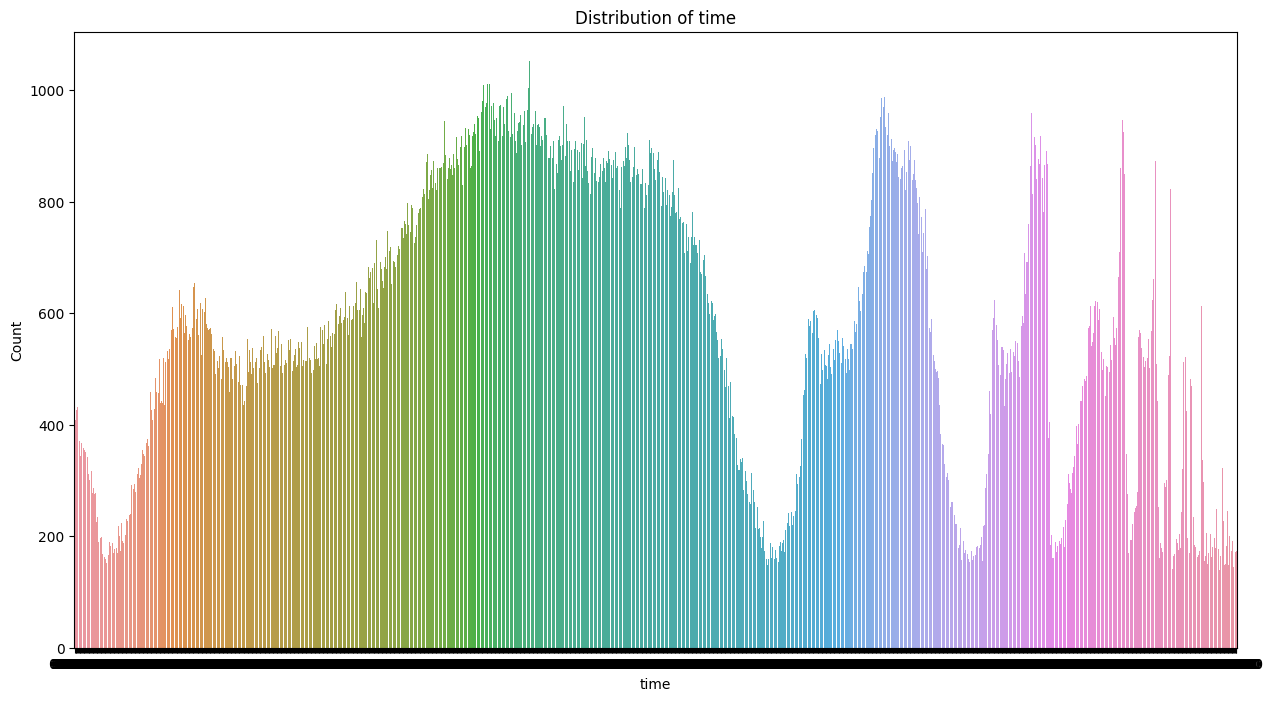

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

for column in df.columns:
    data = df.select(col(column)).toPandas()
    
    plt.figure(figsize=(15,8))
    sns.countplot(x=column, data=data)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title('Distribution of ' + column)
    plt.show()

In [ ]:
!pip install cartopy

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from pyspark.sql.functions import col

west, south, east, north = -74.26, 40.50, -73.70, 40.92
df_lat_lon = df.select(col("Lat"), col("Lon"))
df_pd = df_lat_lon.toPandas()
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection=ccrs.Mercator())
x, y = ax.projection.transform_points(ccrs.PlateCarree(), df_pd['Lon'].values, df_pd['Lat'].values)[:, :2].T
hb = ax.hexbin(x, y, gridsize=1000, bins='log', cmap=cm.YlOrRd_r, alpha=0.5, mincnt=1,
               transform=ccrs.Mercator())

cb = plt.colorbar(hb, location='bottom', pad="10%", label='Pickup Density')
ax.set_title('Uber Pickups in New York City', fontsize=20)
ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

plt.show()

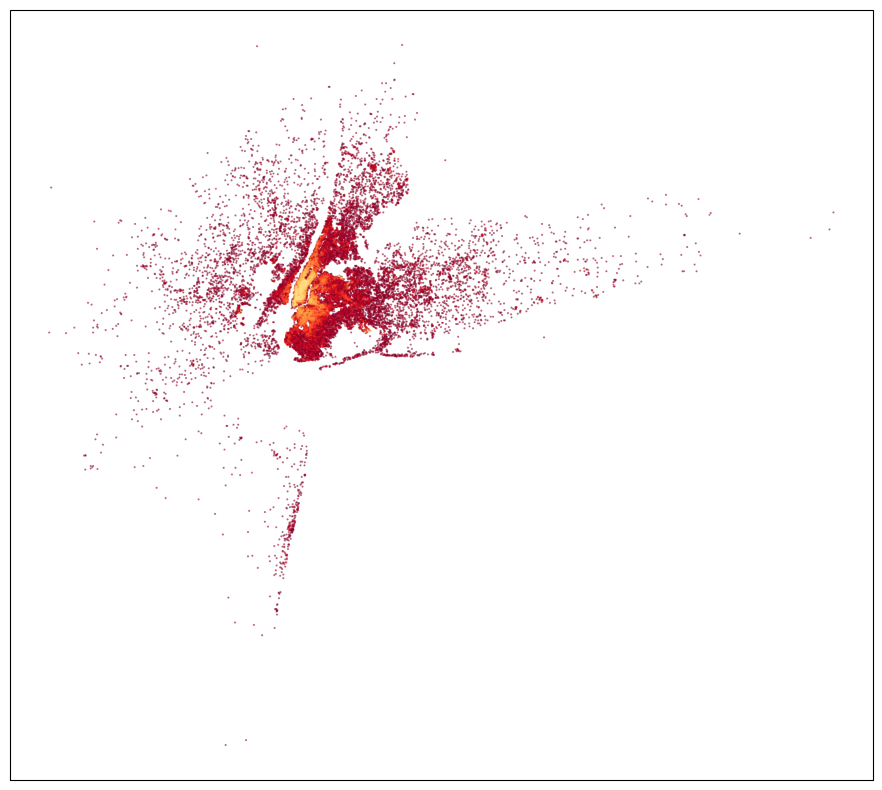

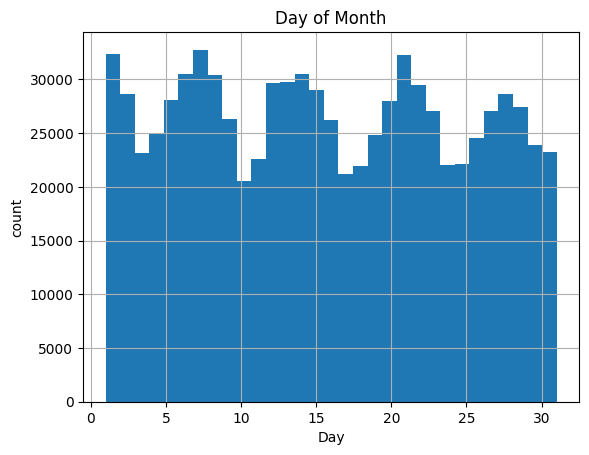

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import dayofweek, dayofmonth, hour

# Convert the Spark DataFrame to a Pandas DataFrame
pdf = df.toPandas()

# Day of month histogram
dom_hist = pdf['Date/Time'].apply(lambda x: pd.Timestamp(x).day).hist(bins=31)
plt.title('Day of Month')
plt.xlabel('Day')
plt.ylabel('count')
plt.show()



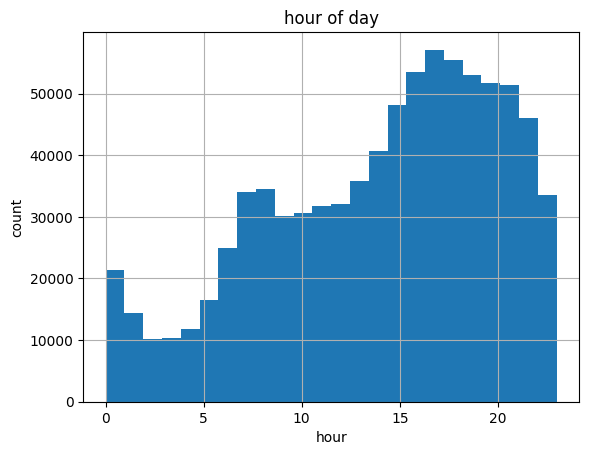

In [5]:
# Day of month histogram
dom_hist = pdf['Date/Time'].apply(lambda x: pd.Timestamp(x).hour).hist(bins=24)
plt.title('hour of day')
plt.xlabel('hour')
plt.ylabel('count')
plt.show()


In [267]:
from pyspark.sql.functions import udf
from datetime import datetime
from pyspark.sql.types import StringType

def get_day_of_week(date_str):
    dt = datetime.strptime(date_str, '%m/%d/%Y %H:%M:%S')
    return dt.strftime('%A')

get_day_of_week_udf = udf(get_day_of_week, StringType())

# Add a new column with the day of the week name
new_df = df.withColumn('DayOfWeekName', get_day_of_week_udf('Date/Time'))


In [268]:
new_df.show(10)

+----------------+-------+--------+------+-------------+
|       Date/Time|    Lat|     Lon|  Base|DayOfWeekName|
+----------------+-------+--------+------+-------------+
|8/1/2014 0:03:00|40.7366|-73.9906|B02512|       Friday|
|8/1/2014 0:09:00| 40.726|-73.9918|B02512|       Friday|
|8/1/2014 0:12:00|40.7209|-74.0507|B02512|       Friday|
|8/1/2014 0:12:00|40.7387|-73.9856|B02512|       Friday|
|8/1/2014 0:12:00|40.7323|-74.0077|B02512|       Friday|
|8/1/2014 0:13:00|40.7349|-74.0033|B02512|       Friday|
|8/1/2014 0:15:00|40.7279|-73.9542|B02512|       Friday|
|8/1/2014 0:17:00| 40.721|-73.9937|B02512|       Friday|
|8/1/2014 0:19:00|40.7195| -74.006|B02512|       Friday|
|8/1/2014 0:20:00|40.7448|-73.9799|B02512|       Friday|
+----------------+-------+--------+------+-------------+
only showing top 10 rows



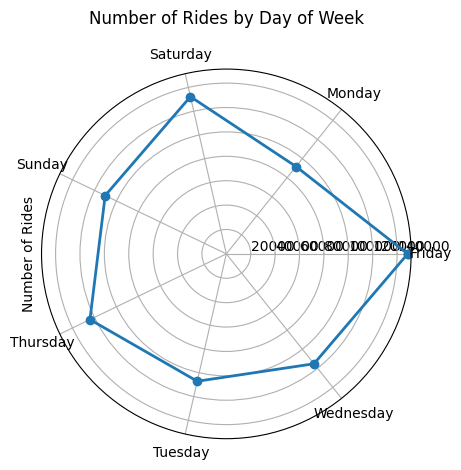

In [128]:
import numpy as np
import matplotlib.pyplot as plt

rides_by_day_of_week = new_df.groupBy('DayOfWeekName').count().orderBy('DayOfWeekName')
days_of_week = rides_by_day_of_week.select('DayOfWeekName').rdd.flatMap(lambda x: x).collect()
num_rides = rides_by_day_of_week.select('count').rdd.flatMap(lambda x: x).collect()

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

n = len(days_of_week)
angles = [i * 2 * np.pi / n for i in range(n)]

num_rides += num_rides[:1]
angles += angles[:1]

ax.plot(angles, num_rides, 'o-', linewidth=2)

ax.set_thetagrids(np.arange(0, 360, 360/n), days_of_week)
ax.set_title('Number of Rides by Day of Week', y=1.1)
ax.set_rlabel_position(0)
ax.set_ylabel('Number of Rides')

plt.show()

In [269]:
from pyspark.sql.functions import split

new_df = new_df.withColumn('date', split(df['Date/Time'], ' ')[0]).withColumn('time', split(df['Date/Time'], ' ')[1]).drop('Date/Time')

In [274]:
new_df.toPandas()

,Date/Time,Lat,Lon,Base,DayOfWeekName,date,time
0,8/1/2014 0:03:00,40.7366,-73.9906,B02512,Friday,8/1/2014,0:03:00
1,8/1/2014 0:09:00,40.7260,-73.9918,B02512,Friday,8/1/2014,0:09:00
2,8/1/2014 0:12:00,40.7209,-74.0507,B02512,Friday,8/1/2014,0:12:00
3,8/1/2014 0:12:00,40.7387,-73.9856,B02512,Friday,8/1/2014,0:12:00
4,8/1/2014 0:12:00,40.7323,-74.0077,B02512,Friday,8/1/2014,0:12:00
...,...,...,...,...,...,...,...
829270,8/31/2014 23:55:00,40.7552,-73.9753,B02764,Sunday,8/31/2014,23:55:00
829271,8/31/2014 23:55:00,40.7552,-73.9753,B02764,Sunday,8/31/2014,23:55:00
829272,8/31/2014 23:55:00,40.7617,-73.9788,B02764,Sunday,8/31/2014,23:55:00
829273,8/31/2014 23:59:00,40.7395,-73.9889,B02764,Sunday,8/31/2014,23:59:00


In [275]:
# Split date and time columns into separate components
new_df = new_df.withColumn("day", split(col("date"), "/")[1].cast("int"))


#Drop original date and time columns
new_df = new_df.drop("date")

ddf = new_df
new_df.show()

+----------------+-------+--------+------+-------------+-------+---+
|       Date/Time|    Lat|     Lon|  Base|DayOfWeekName|   time|day|
+----------------+-------+--------+------+-------------+-------+---+
|8/1/2014 0:03:00|40.7366|-73.9906|B02512|       Friday|0:03:00|  1|
|8/1/2014 0:09:00| 40.726|-73.9918|B02512|       Friday|0:09:00|  1|
|8/1/2014 0:12:00|40.7209|-74.0507|B02512|       Friday|0:12:00|  1|
|8/1/2014 0:12:00|40.7387|-73.9856|B02512|       Friday|0:12:00|  1|
|8/1/2014 0:12:00|40.7323|-74.0077|B02512|       Friday|0:12:00|  1|
|8/1/2014 0:13:00|40.7349|-74.0033|B02512|       Friday|0:13:00|  1|
|8/1/2014 0:15:00|40.7279|-73.9542|B02512|       Friday|0:15:00|  1|
|8/1/2014 0:17:00| 40.721|-73.9937|B02512|       Friday|0:17:00|  1|
|8/1/2014 0:19:00|40.7195| -74.006|B02512|       Friday|0:19:00|  1|
|8/1/2014 0:20:00|40.7448|-73.9799|B02512|       Friday|0:20:00|  1|
|8/1/2014 0:21:00|40.7399|-74.0057|B02512|       Friday|0:21:00|  1|
|8/1/2014 0:25:00|40.7651|-73.9683

In [188]:
ddf.show()

+-------+--------+------+-------------+-------+---+
|    Lat|     Lon|  Base|DayOfWeekName|   time|day|
+-------+--------+------+-------------+-------+---+
|40.7366|-73.9906|B02512|       Friday|0:03:00|  1|
| 40.726|-73.9918|B02512|       Friday|0:09:00|  1|
|40.7209|-74.0507|B02512|       Friday|0:12:00|  1|
|40.7387|-73.9856|B02512|       Friday|0:12:00|  1|
|40.7323|-74.0077|B02512|       Friday|0:12:00|  1|
|40.7349|-74.0033|B02512|       Friday|0:13:00|  1|
|40.7279|-73.9542|B02512|       Friday|0:15:00|  1|
| 40.721|-73.9937|B02512|       Friday|0:17:00|  1|
|40.7195| -74.006|B02512|       Friday|0:19:00|  1|
|40.7448|-73.9799|B02512|       Friday|0:20:00|  1|
|40.7399|-74.0057|B02512|       Friday|0:21:00|  1|
|40.7651|-73.9683|B02512|       Friday|0:25:00|  1|
|40.7354|-74.0081|B02512|       Friday|0:27:00|  1|
|40.7339|-74.0028|B02512|       Friday|0:29:00|  1|
|40.7364|-74.0301|B02512|       Friday|0:29:00|  1|
|40.7364|-74.0301|B02512|       Friday|0:29:00|  1|
|40.7252|-73

In [202]:
ddf.describe()

DataFrame[summary: string, Lat: string, Lon: string, Base: string, DayOfWeekName: string, time: string, day: string]

In [3]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans

spark = SparkSession.builder.appName("KMeansExample").getOrCreate()

data = spark.read.csv("uber-raw-data-aug14.csv", inferSchema=True, header=True)

# convert Base column to numeric using StringIndexer
indexer = StringIndexer(inputCol="Base", outputCol="BaseIndex")
indexed = indexer.fit(data).transform(data)

# assemble the feature vectors
assembler = VectorAssembler(inputCols=["Lat", "Lon", "BaseIndex"], outputCol="features")
data = assembler.transform(indexed)

for k in range(2,11):
    kmeans = KMeans().setK(k).setSeed(20)
    model = kmeans.fit(data)

    # make predictions and extract features and cluster labels
    predictions = model.transform(data)
    features = predictions.select("features").rdd.map(lambda row: row[0]).collect()
    labels = predictions.select("prediction").rdd.map(lambda row: row[0]).collect()

    plt.scatter([f[0] for f in features], [f[1] for f in features], c=labels)
    plt.title('K-means Clustering')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.show()
    print("K = {} / Cost or Sum of Squared Errors = {}".format(k, model.summary.trainingCost))

23/05/02 18:27:27 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


ERROR:root:KeyboardInterrupt while sending command.                 (2 + 2) / 4]
Traceback (most recent call last):
  File "/media/hb/Multimedia/ui/semester 2/big data/HW5/pyspark-logic-regression/.venv/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/media/hb/Multimedia/ui/semester 2/big data/HW5/pyspark-logic-regression/.venv/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

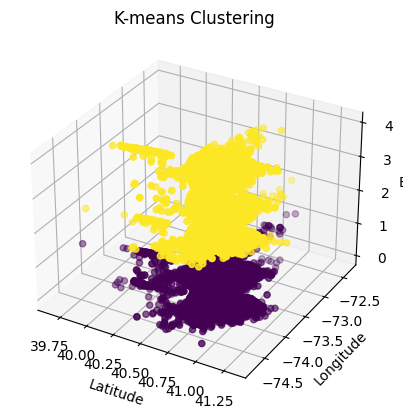

K = 2 / Cost or Sum of Squared Errors = 266081.22502522153


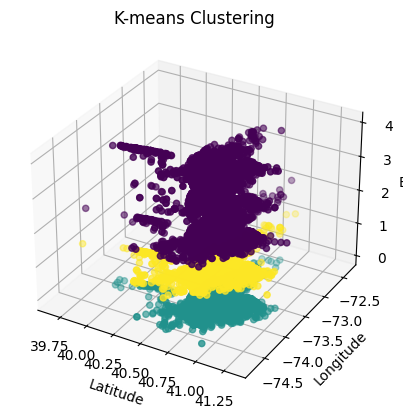

K = 3 / Cost or Sum of Squared Errors = 130088.46048343908


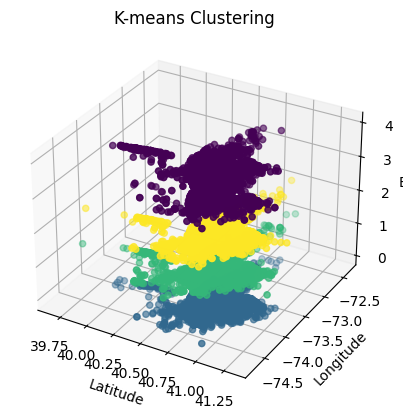

K = 4 / Cost or Sum of Squared Errors = 23813.684657880676


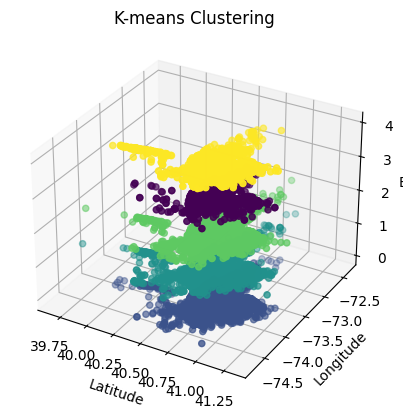

K = 5 / Cost or Sum of Squared Errors = 4710.308305526142


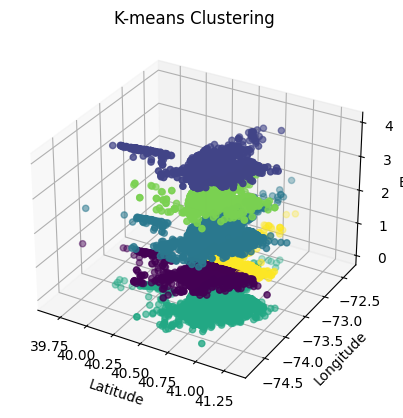

K = 6 / Cost or Sum of Squared Errors = 4235.005988669522


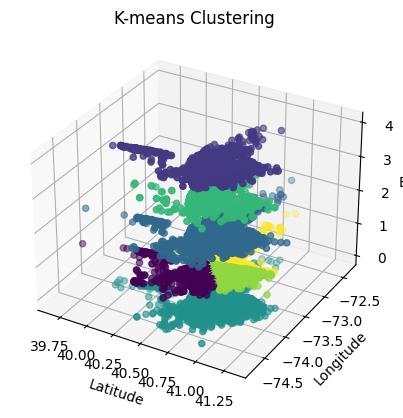

K = 7 / Cost or Sum of Squared Errors = 4079.2383496651655


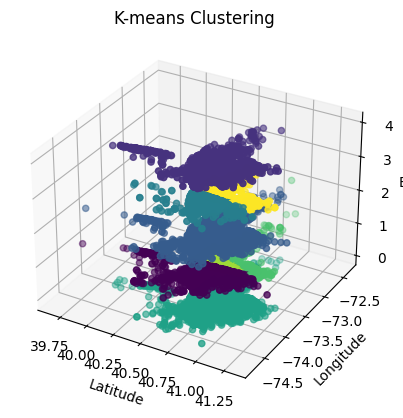

K = 8 / Cost or Sum of Squared Errors = 4035.0788670725015


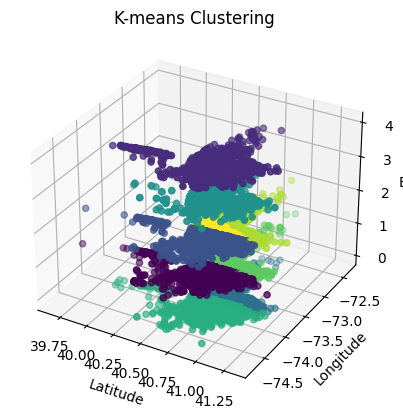

K = 9 / Cost or Sum of Squared Errors = 3064.1254540081613


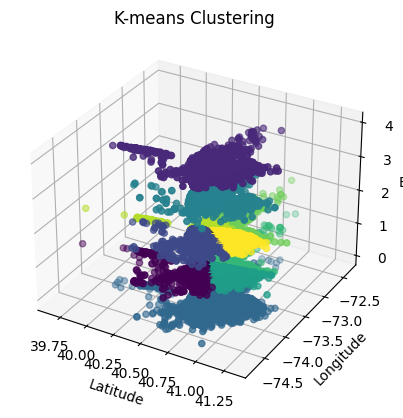

K = 10 / Cost or Sum of Squared Errors = 3511.3215142964136


In [3]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from pyspark.ml.clustering import KMeans

# spark = SparkSession.builder.appName("KMeansExample").getOrCreate()

data = spark.read.csv("uber-raw-data-aug14.csv", inferSchema=True, header=True)

# convert Base column to numeric using StringIndexer
indexer = StringIndexer(inputCol="Base", outputCol="BaseIndex")
indexed = indexer.fit(data).transform(data)

# assemble the feature vectors
assembler = VectorAssembler(inputCols=["Lat", "Lon", "BaseIndex"], outputCol="features")
data = assembler.transform(indexed)

for k in range(2,11):
    kmeans = KMeans().setK(k).setSeed(20)
    model = kmeans.fit(data)

    # make predictions and extract features and cluster labels
    predictions = model.transform(data)
    features = predictions.select("features").rdd.map(lambda row: row[0]).collect()
    labels = predictions.select("prediction").rdd.map(lambda row: row[0]).collect()

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D([f[0] for f in features], [f[1] for f in features], [f[2] for f in features], c=labels)
    ax.set_title('K-means Clustering')
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Base')
    plt.show()
    print("K = {} / Cost or Sum of Squared Errors = {}".format(k, model.summary.trainingCost))


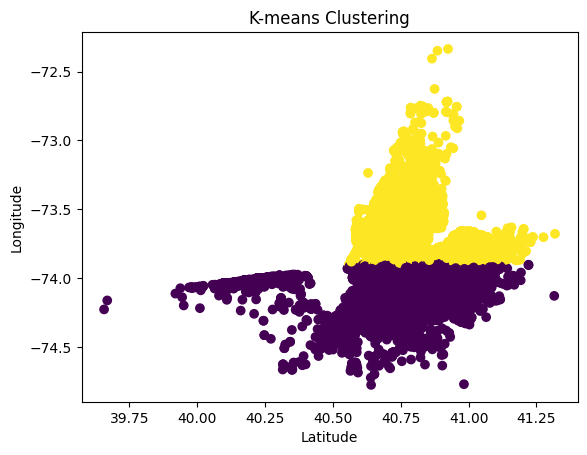

K = 2 / Cost or Sum of Squared Errors = 2945.348238500862


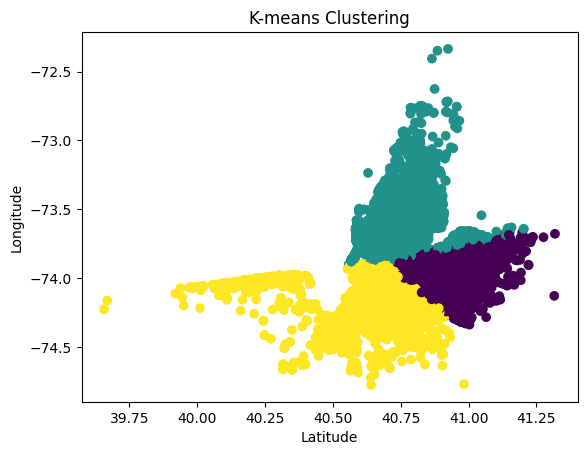

K = 3 / Cost or Sum of Squared Errors = 2338.029056574249


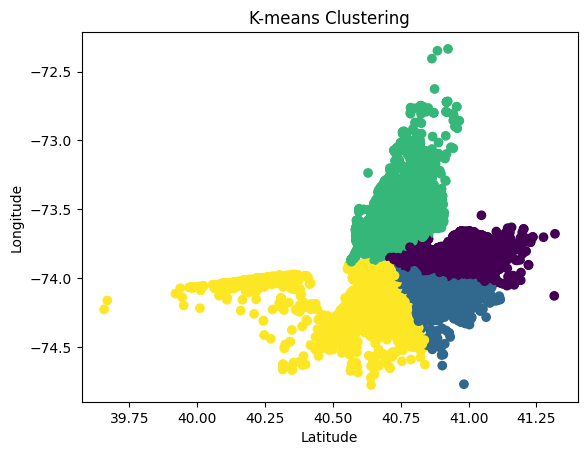

K = 4 / Cost or Sum of Squared Errors = 1937.5263078607413


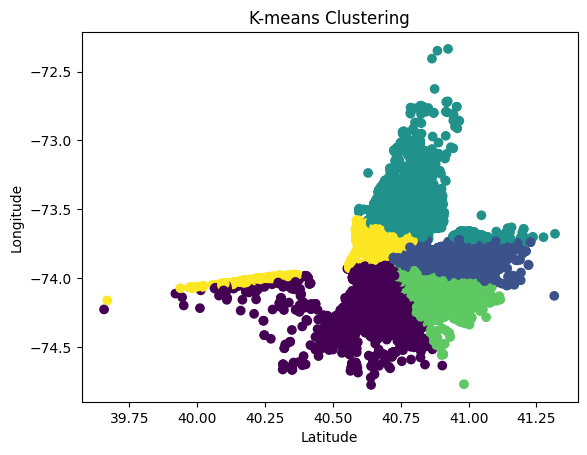

K = 5 / Cost or Sum of Squared Errors = 1706.8436079508394


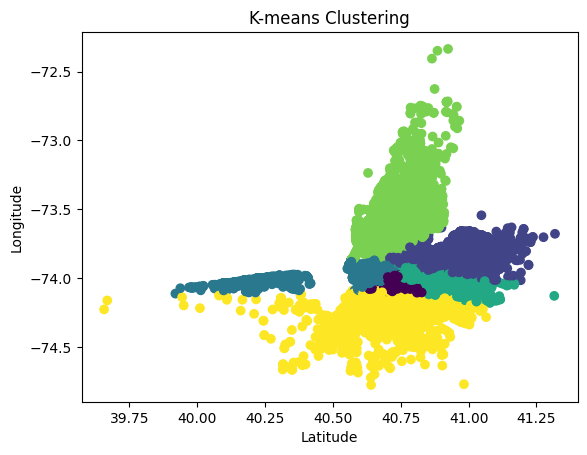

K = 6 / Cost or Sum of Squared Errors = 1301.3363491211292


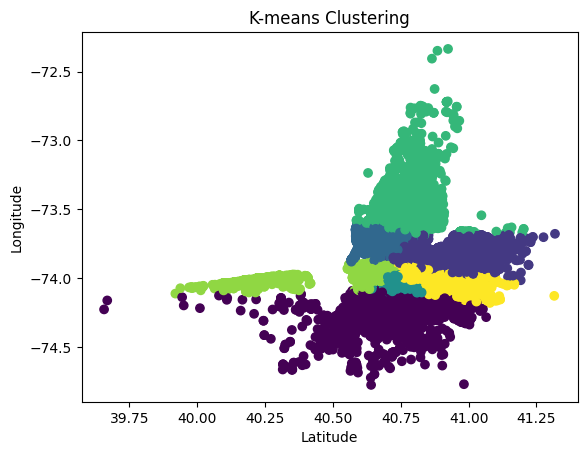

K = 7 / Cost or Sum of Squared Errors = 1076.8606659728584


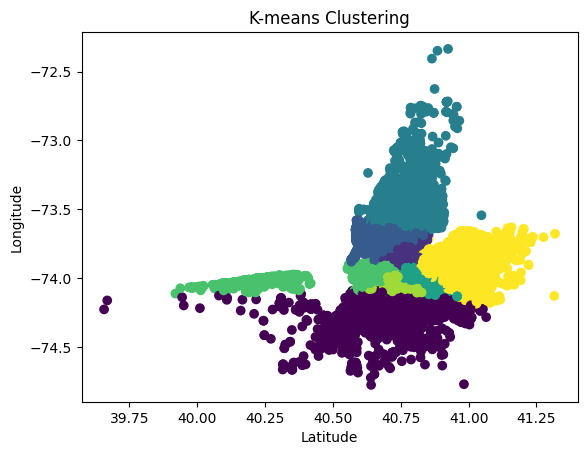

K = 8 / Cost or Sum of Squared Errors = 927.950164812256


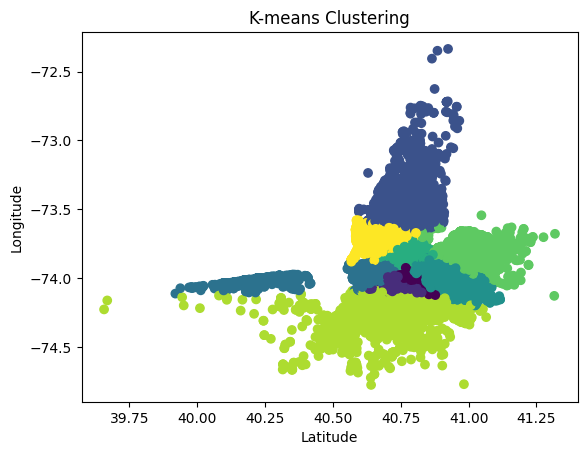

K = 9 / Cost or Sum of Squared Errors = 833.0240190220111


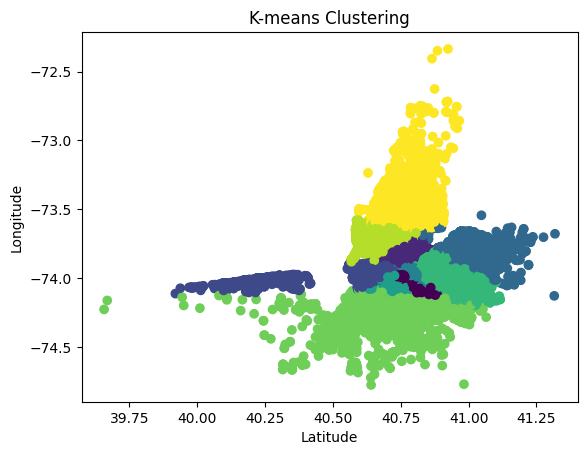

K = 10 / Cost or Sum of Squared Errors = 770.5197762704311


In [7]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans

spark = SparkSession.builder.appName("KMeansExample").getOrCreate()

data = spark.read.csv("uber-raw-data-aug14.csv", inferSchema=True, header=True)


# assemble the feature vectors
assembler = VectorAssembler(inputCols=["Lat", "Lon"], outputCol="features")
data = assembler.transform(data)

    
for k in range(2,11):
    
    kmeans = KMeans().setK(k).setSeed(20)
    model = kmeans.fit(data)
    
    # make predictions and extract features and cluster labels
    predictions = model.transform(data)
    features = predictions.select("features").rdd.map(lambda row: row[0]).collect()
    labels = predictions.select("prediction").rdd.map(lambda row: row[0]).collect()

    plt.scatter([f[0] for f in features], [f[1] for f in features], c=labels)
    plt.title('K-means Clustering')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.show()
    print("K = {} / Cost or Sum of Squared Errors = {}".format(k, model.summary.trainingCost))

## two column has less Error
### used Lat and Lon for features

In [2]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StringIndexer
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans

spark = SparkSession.builder.appName("KMeansExample").getOrCreate()

data = spark.read.csv("uber-raw-data-aug14.csv", inferSchema=True, header=True)

training_data, test_data = data.randomSplit([0.8, 0.2], seed=70)

# assemble the feature vectors
assembler = VectorAssembler(inputCols=["Lat", "Lon"], outputCol="features")
training_data = assembler.transform(training_data).select("features")


kmeans = KMeans().setK(10).setSeed(20)
model = kmeans.fit(training_data)

23/05/02 18:28:59 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [ ]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans().setK(10).setSeed(20)
model = kmeans.fit(training_data)
model.save("kmeans_model_k10.model")

In [5]:
from kafka import KafkaProducer, KafkaConsumer
from pyspark.sql.functions import from_json
from pyspark.sql.types import *

# create a Kafka producer to produce test data
producer = KafkaProducer(bootstrap_servers=['localhost:9092'])


In [31]:
from pyspark.sql.functions import to_json, struct
from kafka import KafkaProducer
import json
from time import sleep

# create a Kafka producer
producer = KafkaProducer(bootstrap_servers=['localhost:9092'], 
                         value_serializer=lambda v: json.dumps(v).encode('utf-8'))

# convert the test_data to a JSON string
test_data_json = test_data.select(to_json(struct([test_data[x] for x in test_data.columns])).alias("value")).collect()

for data in test_data_json:
    producer.send('test_topic', value=data['value'])
    sleep(1)
    print(f"{data['value']}")


{"Date/Time":"8/1/2014 0:00:00","Lat":40.729,"Lon":-73.9422,"Base":"B02598"}
{"Date/Time":"8/1/2014 0:00:00","Lat":40.7424,"Lon":-74.0044,"Base":"B02598"}
{"Date/Time":"8/1/2014 0:01:00","Lat":40.6906,"Lon":-73.9933,"Base":"B02598"}
{"Date/Time":"8/1/2014 0:01:00","Lat":40.7052,"Lon":-74.0094,"Base":"B02598"}
{"Date/Time":"8/1/2014 0:01:00","Lat":40.7403,"Lon":-74.0081,"Base":"B02598"}
{"Date/Time":"8/1/2014 0:01:00","Lat":40.7686,"Lon":-73.9697,"Base":"B02598"}
{"Date/Time":"8/1/2014 0:02:00","Lat":40.8656,"Lon":-73.9274,"Base":"B02598"}
{"Date/Time":"8/1/2014 0:06:00","Lat":40.7069,"Lon":-73.9505,"Base":"B02598"}
{"Date/Time":"8/1/2014 0:06:00","Lat":40.733,"Lon":-73.9875,"Base":"B02598"}
{"Date/Time":"8/1/2014 0:07:00","Lat":40.7952,"Lon":-73.9634,"Base":"B02598"}
{"Date/Time":"8/1/2014 0:08:00","Lat":40.7259,"Lon":-73.9897,"Base":"B02598"}
{"Date/Time":"8/1/2014 0:09:00","Lat":40.726,"Lon":-73.9918,"Base":"B02512"}
{"Date/Time":"8/1/2014 0:09:00","Lat":40.7406,"Lon":-74.0056,"Base"

KeyboardInterrupt: 

In [32]:
from kafka import KafkaConsumer
import json
from pyspark.ml.clustering import KMeansModel
import time

# load the trained KMeans model from file/directory
loaded_model = KMeansModel.load("kmeans_model_k10.model")

# create a Kafka consumer
consumer = KafkaConsumer('test_topic', bootstrap_servers=['localhost:9092'],
                         auto_offset_reset='earliest', 
                         enable_auto_commit=True, 
                         value_deserializer=lambda m: json.loads(m.decode('utf-8')))

for message in consumer:
    start_time = time.time()
    
    data = message.value
    json_object = json.loads(data)
    df = spark.createDataFrame([(json_object['Lat'], json_object['Lon'])], ['Lat', 'Lon'])
    
    # assemble the feature vectors
    assembler = VectorAssembler(inputCols=["Lat", "Lon"], outputCol="features")
    indexed = assembler.transform(df).select("features")

    predictions = loaded_model.transform(indexed)
    
    predictions.show()
    
    end_time = time.time()
    
    print(f"execution time: {end_time - start_time}")
    


+-----------------+----------+
|         features|prediction|
+-----------------+----------+
|[40.729,-73.9422]|         8|
+-----------------+----------+

execution time: 0.9776363372802734
+------------------+----------+
|          features|prediction|
+------------------+----------+
|[40.7424,-74.0044]|         0|
+------------------+----------+

execution time: 0.3352975845336914
+------------------+----------+
|          features|prediction|
+------------------+----------+
|[40.6906,-73.9933]|         4|
+------------------+----------+

execution time: 0.3232746124267578
+------------------+----------+
|          features|prediction|
+------------------+----------+
|[40.7052,-74.0094]|         0|
+------------------+----------+

execution time: 0.3250727653503418
+------------------+----------+
|          features|prediction|
+------------------+----------+
|[40.7403,-74.0081]|         0|
+------------------+----------+

execution time: 0.28444790840148926
+------------------+----

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/home/hb/Downloads/spark-3.3.2-bin-hadoop3/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/hb/Downloads/spark-3.3.2-bin-hadoop3/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


+------------------+----------+
|          features|prediction|
+------------------+----------+
|[40.7535,-73.9721]|         8|
+------------------+----------+

execution time: 0.3013942241668701


KeyboardInterrupt: 

# DASK

In [ ]:
import json
from kafka import KafkaConsumer
import dask.dataframe as dd
from dask_ml.wrappers import ParallelPostFit
import dask
import pandas as pd

@dask.delayed
def predict(df):
    assembler = VectorAssembler(inputCols=["Lat", "Lon"], outputCol="features")
    indexed = assembler.transform(df).select("features")
    predictions = loaded_model.transform(indexed)
    return predictions

# create a Kafka consumer
consumer = KafkaConsumer('test_topic', bootstrap_servers=['localhost:9092'],
                         auto_offset_reset='earliest', 
                         enable_auto_commit=True, 
                         value_deserializer=lambda m: json.loads(m.decode('utf-8')))

# consume the data from the topic and make predictions
for message in consumer:
    data = message.value
    json_object = json.loads(data)
    df = dd.from_pandas(pd.DataFrame([(json_object['Lat'], json_object['Lon'])], columns=['Lat', 'Lon']), npartitions=1)
    
    start_time = time.time()
    predictions = ParallelPostFit(estimator=loaded_model).transform(df)
    result = predictions.compute()
    finish_time = time.time()

#     print(f"Received data: {data}")
    print(f"Predictions: {result}")
    print(f"Execution time: {finish_time - start_time} seconds")